# Example-31: Orbit (dispersion)

In [1]:
# In this example 1st and 2nd order derivatives of closed orbit with respect to momentum deviation are computed
# First, dispersion at BPMs is computed from linear fit and compared with ELEGANT
# Next, 1st and 2ns derivatives of closed orbit are computed

In [2]:
# Import

from pprint import pprint

import torch

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from twiss import twiss

from model.library.line import Line

from model.command.util import select
from model.command.util import chop
from model.command.util import evaluate
from model.command.util import series

from model.command.external import load_sdds
from model.command.external import load_lattice

from model.command.build import build

from model.command.layout import Layout

from model.command.orbit import orbit
from model.command.orbit import parametric_orbit

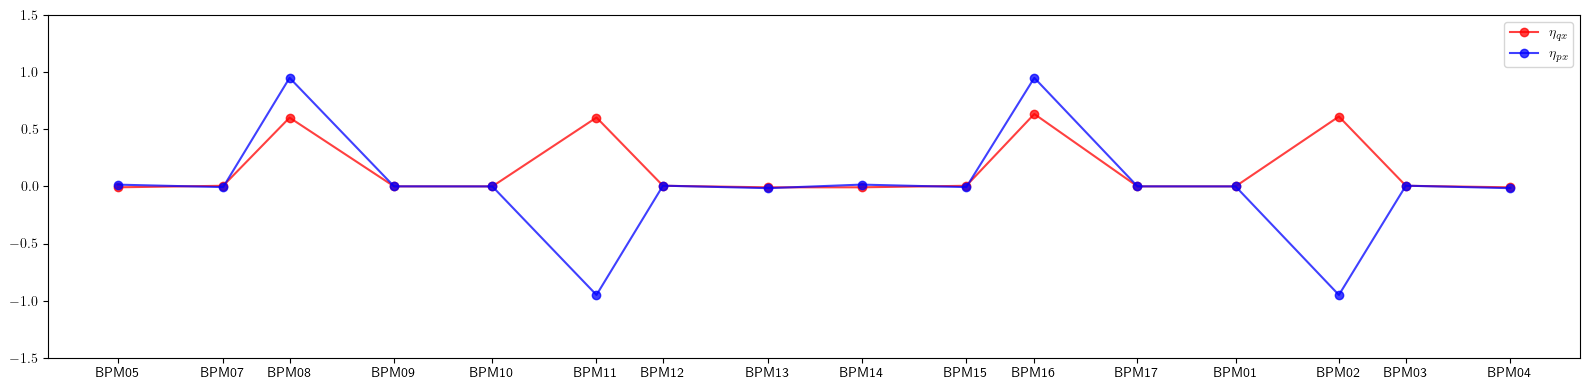

In [3]:
# Load ELEGANT twiss

path = Path('ic.twiss')
parameters, columns = load_sdds(path)

# Set tunes

nu_qx:float = parameters['nux'] % 1
nu_qy:float = parameters['nuy'] % 1

# Set dispersion at monitors

kinds = select(columns, 'ElementType', keep=False)

eta_qx = select(columns, 'etax' , keep=False)
eta_px = select(columns, 'etaxp', keep=False)
eta_qy = select(columns, 'etay' , keep=False)
eta_py = select(columns, 'etayp', keep=False)

eta_qx = {key: value for (key, value), kind in zip(eta_qx.items(), kinds.values()) if kind == 'MONI'}
eta_px = {key: value for (key, value), kind in zip(eta_px.items(), kinds.values()) if kind == 'MONI'}
eta_qy = {key: value for (key, value), kind in zip(eta_qy.items(), kinds.values()) if kind == 'MONI'}
eta_py = {key: value for (key, value), kind in zip(eta_py.items(), kinds.values()) if kind == 'MONI'}

positions = select(columns, 's', keep=False).items()
positions = [value for (key, value), kind in zip(positions, kinds.values()) if kind == 'MONI']

# Plot dispersion at monitors

plt.figure(figsize=(16, 4))
plt.plot(positions, eta_qx.values(), color='red', alpha=0.75, marker='o', label=r'$\eta_{qx}$')
plt.plot(positions, eta_px.values(), color='blue', alpha=0.75, marker='o', label=r'$\eta_{px}$')
plt.xticks(ticks=positions, labels=eta_qx.keys())
plt.legend()
plt.ylim(-1.50, 1.50)
plt.tight_layout()
plt.show()

In [4]:
# Build and setup lattice

path = Path('ic.lte')
data = load_lattice(path)

ring:Line = build('RING', 'ELEGANT', data)
ring.propagate = True
ring.flatten()
ring.merge()
ring.split((None, ['BPM'], None, None))
ring.roll(1)
ring.splice()

In [5]:
# Generate data for layout plot

layout = Layout(ring)
rectangles = layout.profile_1d(scale=0.75, shift=-1.25, text=False,  exclude=['BPM'])

In [6]:
# Compare linear tunes

state = torch.tensor(4*[0.0], dtype=torch.float64)

matrix = torch.func.jacrev(ring)(state)

(nuqx, nuqy), *_ = twiss(matrix)

print(nu_qx - nuqx)
print(nu_qy - nuqy)

tensor(3.1086e-15, dtype=torch.float64)
tensor(5.5511e-16, dtype=torch.float64)


In [7]:
# First, we use orbit funtion to compute dispersion from linear fit

dps = torch.linspace(-1.0E-6, 1.0E-6, 5, dtype=torch.float64)

def fn(dp):
    guess = torch.tensor(4*[0.0], dtype=torch.float64)    
    table, *_ = orbit(ring, 
                      guess, 
                      [dp], 
                      ('dp', None, None, None), 
                      alignment=False, 
                      advance=True, 
                      full=False, 
                      limit=16,
                      epsilon=None)
    return table

data = torch.func.vmap(fn)(dps).swapaxes(0, 1)
print(data.shape)
print()

solution = torch.linalg.lstsq(dps.unsqueeze(1).expand(16, -1, -1), data).solution.squeeze()
etaqx, etapx, etaqy, etapy = solution.T

print(solution)
print()

torch.Size([16, 5, 4])

tensor([[-8.0639e-03,  1.5204e-02, -1.6705e-47, -1.0023e-46],
        [ 5.4760e-03, -6.2632e-03, -1.1567e-46, -2.1361e-46],
        [ 6.0119e-01,  9.4899e-01, -1.2796e-46,  1.6479e-46],
        [ 2.1306e-04,  3.5665e-04, -1.7803e-48,  1.0495e-46],
        [ 1.9312e-04, -3.4532e-04,  1.3538e-46,  2.0140e-46],
        [ 6.0213e-01, -9.4895e-01,  2.2986e-47, -7.7907e-47],
        [ 5.5166e-03,  6.3179e-03, -5.1114e-47, -2.4426e-47],
        [-8.2339e-03, -1.5569e-02, -1.8418e-46,  2.8539e-46],
        [-8.0136e-03,  1.5570e-02, -6.4499e-47, -3.5286e-47],
        [ 5.4415e-03, -6.2309e-03,  7.7971e-47,  1.9323e-46],
        [ 6.3304e-01,  9.4904e-01,  1.1570e-46, -1.0752e-46],
        [ 1.4893e-04,  2.5326e-04,  5.7455e-47, -1.7626e-46],
        [ 1.4627e-04, -2.5477e-04, -1.1789e-46, -2.1735e-46],
        [ 6.1073e-01, -9.4905e-01, -7.4501e-47, -4.1134e-48],
        [ 5.4673e-03,  6.2236e-03, -5.9414e-48,  1.1262e-46],
        [-8.1900e-03, -1.5703e-02,  1.4993e-46

In [8]:
# Compare fitted values with ELEGANT

print(etaqx - torch.tensor([*eta_qx.values()], dtype=torch.float64))
print()

print(etapx - torch.tensor([*eta_px.values()], dtype=torch.float64))
print()

tensor([ 2.2442e-10, -2.2744e-10,  6.9459e-11,  7.6277e-11, -1.3798e-10,
        -5.3663e-11,  1.4376e-10, -1.7885e-10, -1.6939e-10,  1.5748e-10,
        -6.4322e-11,  5.5576e-13,  1.0362e-10, -3.3488e-11, -1.3350e-10,
         2.5610e-10], dtype=torch.float64)

tensor([-4.5285e-10,  3.1612e-10,  2.4220e-10,  1.5288e-11,  1.1806e-10,
         1.3037e-10,  1.9701e-10, -3.3796e-10,  3.3938e-10, -2.2205e-10,
        -1.9500e-10,  5.4374e-11, -1.2243e-10, -8.7487e-12, -1.3556e-10,
         4.6687e-10], dtype=torch.float64)



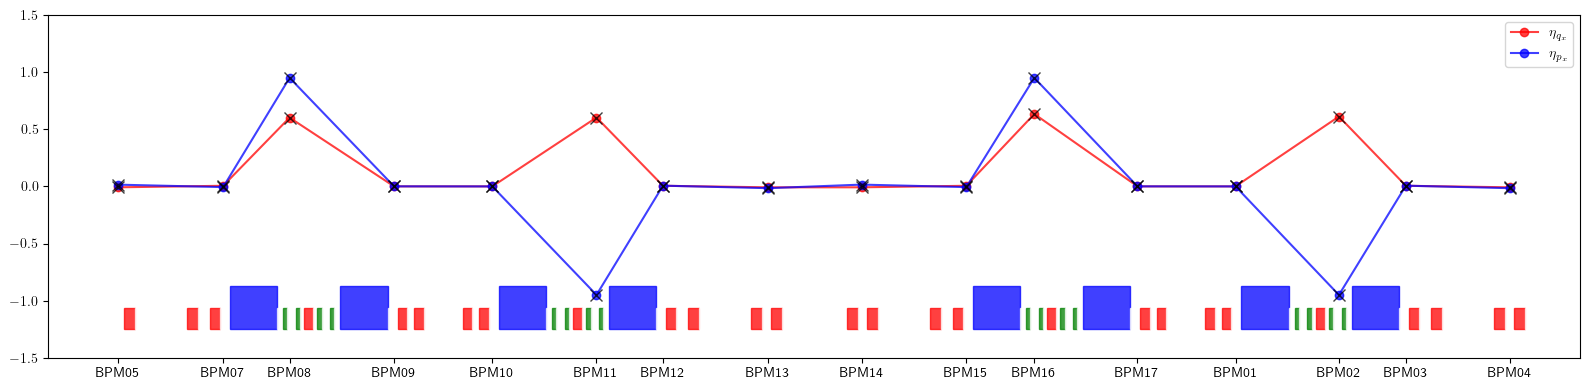

In [9]:
# Plot dispersion

plt.figure(figsize=(16, 4))
plt.plot(positions, eta_qx.values(), color='red', alpha=0.75, marker='o', label=r'$\eta_{q_x}$')
plt.plot(positions, eta_px.values(), color='blue', alpha=0.75, marker='o', label=r'$\eta_{p_x}$')
plt.errorbar(ring.locations().cpu().numpy(), etaqx.cpu().numpy(), fmt=' ', ms=8, color='black', alpha=0.75, marker='x')
plt.errorbar(ring.locations().cpu().numpy(), etapx.cpu().numpy(), fmt=' ', ms=8, color='black', alpha=0.75, marker='x')
plt.xticks(ticks=positions, labels=eta_qx.keys())
plt.legend()
for rectangle in rectangles:
    plt.gca().add_patch(Rectangle(**rectangle))
plt.ylim(-1.50, 1.50)
plt.tight_layout()
plt.show()

In [10]:
# Compute parametric closed orbit (1st and 2nd derivatives of closed orbit with respect to momentum deviation)
# Note, all parameters after groups are shown with default values

fp = torch.tensor(4*[0.0], dtype=torch.float64)
dp = torch.tensor(1*[0.0], dtype=torch.float64)

def solve(matrix, vector):
    return torch.linalg.lstsq(matrix, vector.unsqueeze(1)).solution.squeeze()

orbits, table, orders = parametric_orbit(ring,                              # -- input line
                                         fp,                                # -- dynamical closed orbit (at given starting location)
                                         [dp],                              # -- list of deviation variables
                                         (1 + 1, 'dp', None, None, None),   # -- deviation variables group(s), (order, key, kinds, names and names to exclude)
                                         start=None,                        # -- new lattice start
                                         alignment=False,                   # -- flag to use alignment
                                         advance=True,                      # -- flag to propagate orbit (orbits for at the end of all first level elements/lines are returned)
                                         full=False,                        # -- full propagation flag (compute and return orbit at the last element/line, should match the first element of the output)
                                         power=1,                           # -- fixed point power/order
                                         solve=solve,                       # -- linear system solver (A x = b)
                                         jacobian=torch.func.jacrev)        # -- jacobian

In [11]:
# Deviation groups specification is similar to command.wrapper.group or command.orbit.orbit, with first element being the derivative order

# Here, only one group (1 + 1, 'dp', None, None, None) is used
# 1 + 1 -- derivative order with respect to dp
# 'dp'  -- deviation paramter to bind in matched elements (see element.data())
# None  -- list of element kinds to match (use None to match all or a list of kinds)
# None  -- list of element names to match (use None to match all or a list of names)
# None  -- list of element names to exclude (use None to exclude none or a list of names) 

# Several groups can be passed
# In this case list of deviation variables is expected to match
# Table returns group info in command.wrapper.wrapper format

print(table)

# Tuple of derivative orders is also returned
# The computed derivative is partial with respect to deviation groups
# See Example-01 and Example-02 in https://i-a-morozov.github.io/ndmap/examples/ndmap.html for details

print(orders)

[(None, None, 'dp')]
(2,)


In [12]:
# Each orbit in orbits is represented as a special Table

# This is a redundent multivariate series representation
# It can be evaluated using model.command.util.evaluate function (alias of ndmap.evaluate.evaluate)
# model.command.util.chop can be used to clean small values (alias of ndmap.signature.chop)

local, *_ = orbits
chop(local)

pprint(local)
print()

# Evaluate table at non-zero deviation
# Note, here dynamical fixed point is required but has no effect

print(evaluate(local, [fp, dp + 1.0E-3]))
print()

# With only one deviation group the above is equivalent to 

(x, dxdp, dxdpdp), *_ = local
print(x + dxdp @ (dp + 1.0E-3) + 0.5 * dxdpdp @ (dp + 1.0E-3) @ (dp + 1.0E-3))
print()

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[-0.0081],
        [ 0.0152],
        [ 0.0000],
        [ 0.0000]], dtype=torch.float64),
  tensor([[[-14.6125]],

        [[ 24.3816]],

        [[  0.0000]],

        [[  0.0000]]], dtype=torch.float64)]]

tensor([-1.5370e-05,  2.7395e-05,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64)

tensor([-1.5370e-05,  2.7395e-05,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64)



In [13]:
# Derivative table representation can be also converted to series using model.command.util.series function (alias of ndmap.series.series)

local, *_ = orbits
pprint(series((4, 1), (0, 1 + 1), local))
print()

# model.command.util.evaluate can also be used with series

print(evaluate(local, [fp, dp + 1.0E-3]))
print()

print(evaluate(series((4, 1), (0, 1 + 1), local), [fp, dp + 1.0E-3]))
print()

{(0, 0, 0, 0, 0): tensor([0., 0., 0., 0.], dtype=torch.float64),
 (0, 0, 0, 0, 1): tensor([-0.0081,  0.0152,  0.0000,  0.0000], dtype=torch.float64),
 (0, 0, 0, 0, 2): tensor([-7.3062, 12.1908,  0.0000,  0.0000], dtype=torch.float64)}

tensor([-1.5370e-05,  2.7395e-05,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64)

tensor([-1.5370e-05,  2.7395e-05,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64)



In [14]:
# Extract 1st and 2nd order dispersion values from series representation

eta1_qx = torch.stack([series((4, 1), (0, 2), local)[(0, 0, 0, 0, 1)][0] for local in orbits])
eta1_px = torch.stack([series((4, 1), (0, 2), local)[(0, 0, 0, 0, 1)][1] for local in orbits])

eta2_qx = torch.stack([series((4, 1), (0, 2), local)[(0, 0, 0, 0, 2)][0] for local in orbits])
eta2_px = torch.stack([series((4, 1), (0, 2), local)[(0, 0, 0, 0, 2)][1] for local in orbits])

In [15]:
# Compare with ELEGANT

print(eta1_qx - torch.tensor([*eta_qx.values()], dtype=torch.float64))
print()

print(eta1_px - torch.tensor([*eta_px.values()], dtype=torch.float64))
print()

tensor([ 1.0004e-14, -1.3037e-14,  5.9952e-15,  1.2807e-15, -9.5464e-15,
         1.3323e-15,  9.5436e-15, -1.4350e-14, -1.3914e-14,  9.5748e-15,
         8.8818e-16, -8.9525e-15,  5.2589e-16,  6.7724e-15, -1.3343e-14,
         9.5809e-15], dtype=torch.float64)

tensor([-2.1778e-14,  1.9190e-14,  1.4433e-14, -3.7748e-15,  1.0540e-14,
         3.9968e-15,  1.0880e-14, -2.7096e-14,  2.7100e-14, -1.1074e-14,
        -4.1078e-15, -1.0103e-14,  4.2984e-15, -1.5210e-14, -2.0095e-14,
         2.1663e-14], dtype=torch.float64)



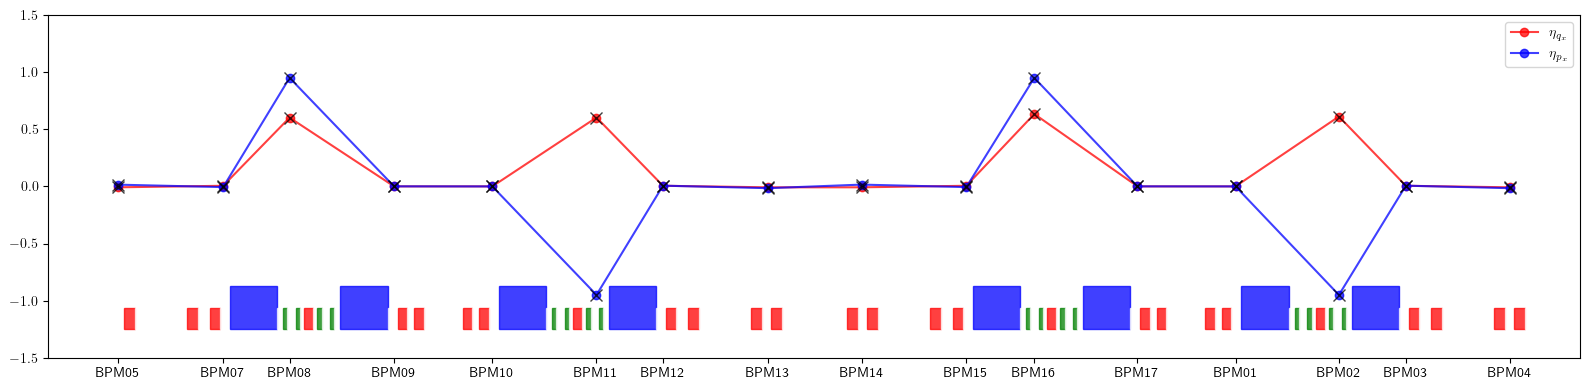

In [16]:
# Plot dispersion

plt.figure(figsize=(16, 4))
plt.plot(positions, eta_qx.values(), color='red', alpha=0.75, marker='o', label=r'$\eta_{q_x}$')
plt.plot(positions, eta_px.values(), color='blue', alpha=0.75, marker='o', label=r'$\eta_{p_x}$')
plt.errorbar(ring.locations().cpu().numpy(), eta1_qx.cpu().numpy(), fmt=' ', ms=8, color='black', alpha=0.75, marker='x')
plt.errorbar(ring.locations().cpu().numpy(), eta1_px.cpu().numpy(), fmt=' ', ms=8, color='black', alpha=0.75, marker='x')
plt.xticks(ticks=positions, labels=eta_qx.keys())
plt.legend()
for rectangle in rectangles:
    plt.gca().add_patch(Rectangle(**rectangle))
plt.ylim(-1.50, 1.50)
plt.tight_layout()
plt.show()

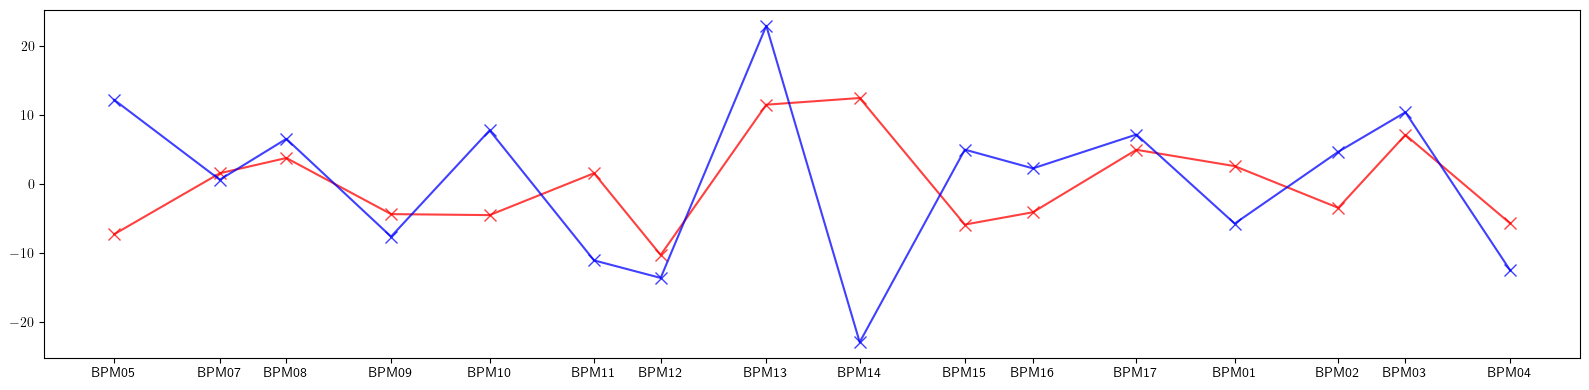

In [17]:
# Plot second order dispersion

plt.figure(figsize=(16, 4))
plt.errorbar(ring.locations().cpu().numpy(), eta2_qx.cpu().numpy(), fmt='-', ms=8, color='red', alpha=0.75, marker='x')
plt.errorbar(ring.locations().cpu().numpy(), eta2_px.cpu().numpy(), fmt='-', ms=8, color='blue', alpha=0.75, marker='x')
plt.xticks(ticks=positions, labels=eta_qx.keys())
plt.tight_layout()
plt.show()

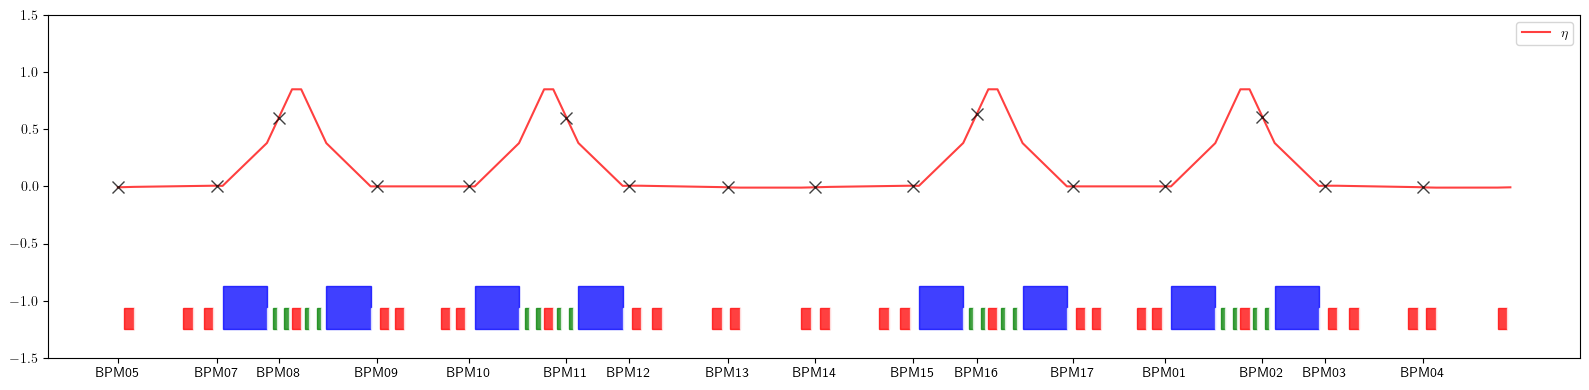

In [18]:
# Compute dispersion at the exit of each element

ring.flatten()

fp = torch.tensor(4*[0.0], dtype=torch.float64)
dp = torch.tensor(1*[0.0], dtype=torch.float64)

orbits, *_ = parametric_orbit(ring, fp, [dp], (1, 'dp', None, None, None), advance=True, full=True)

dispersion = torch.stack([series((4, 1), (0, 2), local)[(0, 0, 0, 0, 1)][0] for local in orbits])

plt.figure(figsize=(16, 4))
plt.errorbar(ring.locations('all').cpu().numpy(), dispersion.cpu().numpy(), fmt='-', color='red', alpha=0.75, label=r'$\eta$')
plt.errorbar(positions, eta_qx.values(), fmt=' ', ms=8, color='black', alpha=0.75, marker='x')
plt.xticks(ticks=positions, labels=eta_qx.keys())
plt.legend()
for rectangle in rectangles:
    plt.gca().add_patch(Rectangle(**rectangle))
plt.ylim(-1.50, 1.50)
plt.tight_layout()
plt.show()